# Search-Based SWEN Exercise
## Exercise 01 - Traveling Salesman Problem Introduction
<center>
    
    Softwaresysteme - Summer Term 2024

    Sonja Klein / 3794693
    
</center>


**Aufgabe 1: Wissen**
- a) Welche Voraussetzung(en) erfüllen viele Optimierungsprobleme im Software Engineering
nicht, damit Gradienten-basierte Verfahren (wie bspw. Gradient Descent) eingesetzt
werden könnten?
    - Man muss die Fähigkeit haben, die erste Ableitung zu berechnen
    - Oft kennen wir die Funktion nicht einmal (e.g., in black-box scenarios)! 
    - Wir wissen nur wie man eine Lösung erstellen, verändern und testen kann.
    - Außerdem funktioniert das Gradienten-basierte Verfahren nicht für nicht-differenzierbare Funktionen!
- b) Was ist eine Heuristik und in welchen Fällen wird sie typischerweise angewandt?
    - Eine Heuristik ist eine Hilfe zum Lernen, zur Entdeckung oder zu Problemlösung durch experimentelle Methoden, insbesondere durch Versuch und Irrtum. Sie wird typischerweise angewandt wenn eine nahezu optimale Lösung gerade gut genug ist und man auf die optimale Lösung nicht so einfach kommt (wenn das Problem z.B. NP-schwer ist).
- c) Wofür steht das *„Meta“* in Meta-Heuristik und welchen Bezug hat der Begriff zur
Heuristik?
    - Das *"Meta"* steht für eine allgemeine Heuristik, eine bei der Domänenwissen fehlt. Bei Meta-Heuristik handelt es sich um eine Gruppe von Algorithmen, die immer einen Grad an Zufall haben um die optimale Lösung zu schweren Problemen zu finden ohne Domänenwissen anzuwenden.
- d) Welche beiden Aspekte balanciert jedes Optimierungsverfahren?
    - Die Exploration und die Exploitation. 
- e) Was macht einen Such-Algorithmus „global“?
    - Ein Such-Algorithmus wird global, wenn er zumindest theoretisch das globale Optimum findet. Oft muss der Algorithmus dafür unendlich laufen um jede mögliche Lösung einmal zu besuchen. 

**Aufgabe 2: Travelling Salesperson Problem / Problem der Handlungsreisenden**

Das Travelling Salesperson Problem (TSP) beschreibt die Suche nach der kürzesten
Rundreise über eine gegebene Menge von Städten und deren Entfernungen untereinander.
Nutzen Sie die Datei city100.txt sowie die in der Übung diskutierten Quelltexte als Grundlage
für die Lösungsansätze in den folgenden Teilaufgaben.
- a) Implementieren Sie [Steepest Ascent Hill Climbing](#steepest-ascent-hill-climbing) auf dem Traveling-Salesman-Problem.
- b) Implementieren Sie [Steepest Ascent Hill Climbing mit Ersetzen](#steepest-ascent-hill-climbing-replace) auf dem TSP.
- c) Implementieren Sie [Simulated Annealing](#simulated-annealing) auf dem TSP.
- d) Implementieren Sie [Tabu Search](#tabu-search) auf dem TSP.
- e) Implementieren Sie [Iterated Local Search (ILS)](#ils) auf dem TSP

(maybe look at the helper methods in the ex01_introduction.ipynb)


Basic functions that we use

In [1]:
import datetime  
import random
from copy import deepcopy # Copy procedure

def distance(p1, p2):
    """
    Returns the Euclidean distance of two points in the Cartesian Plane.
    """
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) ** 0.5

def tour_length(matrix, tour):
    """Sum up the total length of the tour based on the distance matrix"""
    result = 0
    num_cities = len(list(tour))
    for i in range(num_cities):
        j = (i+1) % num_cities
        city_i = tour[i]
        city_j = tour[j]
        result += matrix[city_i, city_j]
    return result

Read City Coordinates from File and create matrix

In [2]:
def cartesian_matrix(coordinates):
    '''
    Creates a distance matrix for the city coords using straight line distances
    computed by the Euclidean distance of two points in the Cartesian Plane.
    '''
    matrix = {}
    for i, p1 in enumerate(coordinates):
        for j, p2 in enumerate(coordinates):
            matrix[i,j] = distance(p1,p2)
    return matrix

def read_coords(file_handle):
    coords = []
    for line in file_handle:
        x,y = line.strip().split(',')
        coords.append((float(x), float(y)))
    return coords

with open('city100.txt', 'r') as coord_file:
    coords = read_coords(coord_file)
matrix = cartesian_matrix(coords)

# for k, v in matrix.items(): # to see the results of the matrix
    # print(k, v)

(0, 0) 0.0
(0, 1) 349.36240166750815
(0, 2) 419.79860079502356
(0, 3) 423.1179368135718
(0, 4) 365.4122930378598
(0, 5) 42.05076685677476
(0, 6) 507.65366019933964
(0, 7) 274.7285833426368
(0, 8) 237.0037996635846
(0, 9) 120.87601285356801
(0, 10) 184.21310665287896
(0, 11) 439.2490823188776
(0, 12) 452.49732142755295
(0, 13) 459.6129555350416
(0, 14) 216.5511736567214
(0, 15) 525.2569905868042
(0, 16) 427.6764093658136
(0, 17) 404.29848150980797
(0, 18) 295.8971907024211
(0, 19) 174.5869223902092
(0, 20) 153.79957753584586
(0, 21) 220.11766309320026
(0, 22) 305.4824753885715
(0, 23) 305.2119338250488
(0, 24) 362.5639733856575
(0, 25) 384.0716292646907
(0, 26) 388.0979904141658
(0, 27) 385.5178202493056
(0, 28) 334.334191559791
(0, 29) 414.0520040607505
(0, 30) 124.61167807033469
(0, 31) 155.7904334204157
(0, 32) 539.570738661636
(0, 33) 299.80657223861607
(0, 34) 233.87640157731363
(0, 35) 29.000334995872027
(0, 36) 354.04835761534656
(0, 37) 533.4589740415798
(0, 38) 257.181849874626

### <span name="basic-hill-climbing" style="color:orchid">Basic Hill Climbing</span>
<span style="">It starts with an arbitrary solution to a problem, then attempts to find a better solution by making an incremental change to the solution. If the change produces a better solution, another incremental change is made to the new solution, and so on until no further improvements can be found. </span>
<span style="color:red">With swapped cities generator as the **move_operator**: tweaking means two cities are being changed</span>
- **Initialization function**: Provide one initial tour at random (method: init_random_tour)
- **Objective Function**: Return how "good" a solution is: length of the tour (method: tour_length)

In [3]:
import random
def init_random_tour(tour_length):
    tour = list(range(tour_length))
    random.shuffle(tour)
    return tour

init_function = lambda: init_random_tour(len(coords))
objective_function = lambda tour: tour_length(matrix, tour)

In [4]:
def all_pairs(size, shuffle = random.shuffle):
    r1 = list(range(size))
    r2 = list(range(size))
    if shuffle:
        shuffle(r1)
        shuffle(r2)
    for i in r1:
        for j in r2:
            yield(i,j) # yield is an iterator function
            # for each call of the generator it returns the next value in yield
            
# Tweak 1
def swapped_cities(tour):
    """
    Generator to create all possible variations where two 
    cities have been swapped
    """
    ap = all_pairs(len(tour))
    for i,j in ap:
        if i < j:
            copy = deepcopy(tour)
            copy[i], copy[j] = tour[j], tour[i]
            yield copy

In [5]:
def hc(init_function, move_operator, objective_function, max_evaluations, history=None):
    '''
    Hillclimb until either max_evaluations is reached or we are at a local optimum.
    '''
    best = init_function() # what is our current best solution S
    best_score = objective_function(best) # and what is the current best score we could achieve
    
    num_evaluations = 1 # counter for how many solutions we have tested, if it reaches max_evaluations we stop
    
    while num_evaluations < max_evaluations:
        # move around the current position
        move_made = False
        for candidate in move_operator(best): # get all possible tweaks from the move_operator we chose with the current best
            if num_evaluations >= max_evaluations:
                break
            
            candidate_score = objective_function(candidate)
            num_evaluations += 1
            if candidate_score < best_score:
                best = candidate
                best_score = candidate_score
                move_made = True
                break # depth first search
            if history:
                history.log(best, candidate)
        if not move_made:
            break # couldn't find better move - must be a local max
    return (num_evaluations, best_score, best)

Basic Plotting (copied)

In [6]:
from IPython.display import HTML, display, clear_output, update_display
from PIL import Image, ImageDraw, ImageFont
import random
import time


class History:
    def __init__(self, plot_slowdown=0.0001):
        self.tours = []
        self.last_plot = time.time()
        self.plot_slowdown = plot_slowdown

    def first_log(self):
        return len(self.tours) == 0

    def log(self, best, candidate):
        if not self.tours or time.time() - self.last_plot > 1:
            filename = "test" + str(max_evaluations) + ".PNG"
            tours = {"black": candidate, "red": best}
            self.write_tours_to_img(coords, tours, filename, open(filename, "ab"))
            self.tours.append(best)
            self.last_plot = time.time()
        elif self.plot_slowdown:
            time.sleep(self.plot_slowdown)

    def write_tours_to_img(self, coords, tours, title, img_file):
        coords = deepcopy(coords)
        padding = 20
        # shift all coords a bit inwards
        coords = [(x + padding, y + padding) for (x, y) in coords]
        maxx, maxy = 0, 0
        for x, y in coords:
            maxx = max(x, maxx)
            maxy = max(y, maxy)
        maxx += padding
        maxy += padding
        img = Image.new("RGB", (int(maxx), int(maxy)), color=(255, 255, 255))

        font = ImageFont.load_default()
        d = ImageDraw.Draw(img)
        for color, tour in tours.items():
            num_cities = len(tour)
            for i in range(num_cities):
                j = (i + 1) % num_cities
                city_i = tour[i]
                city_j = tour[j]
                x1, y1 = coords[city_i]
                x2, y2 = coords[city_j]
                d.line((int(x1), int(y1), int(x2), int(y2)), fill=color)
                d.text((int(x1) + 7, int(y1) - 5), str(i), font=font, fill=(32, 32, 32))

        for x, y in coords:
            x, y = int(x), int(y)
            d.ellipse(
                (x - 5, y - 5, x + 5, y + 5), outline=(0, 0, 0), fill=(196, 196, 196)
            )

        del d
        display_id = title
        if self.first_log():
            display(img, display_id=display_id)
        else:
            update_display(img, display_id=display_id, clear=False)
        if self.plot_slowdown:
            time.sleep(self.plot_slowdown)

In [7]:
def do_hc_evaluations(evaluations, move_operator=swapped_cities, plot_slowdown=0):
    max_evaluations = evaluations
    then = datetime.datetime.now()
    history = History(plot_slowdown=plot_slowdown)
    num_evaluations, best_score, best = hc(
        init_function,
        move_operator,
        objective_function,
        max_evaluations,
        history=history,
    )
    now = datetime.datetime.now()
    print("computation time ", now - then)
    print("best score:", best_score)
    print("best route:", best)
    print("number of evaluations done:", num_evaluations)

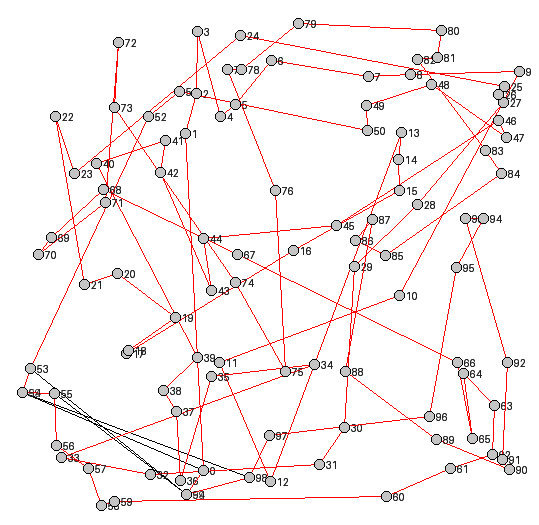

computation time  0:00:03.099798
best score: 9945.777441115937
best route: [77, 1, 78, 54, 90, 97, 48, 47, 71, 55, 42, 79, 60, 13, 64, 62, 74, 9, 30, 19, 96, 10, 36, 18, 84, 76, 95, 72, 75, 28, 81, 87, 92, 35, 57, 20, 66, 99, 50, 31, 22, 63, 23, 14, 38, 83, 58, 37, 53, 52, 11, 26, 41, 73, 86, 56, 39, 0, 68, 5, 33, 24, 17, 91, 98, 27, 25, 43, 67, 34, 21, 88, 16, 61, 8, 59, 49, 3, 51, 65, 94, 32, 15, 45, 6, 4, 85, 80, 7, 70, 89, 29, 40, 12, 93, 2, 46, 82, 69, 44]
number of evaluations done: 5000


In [8]:
move_operator = swapped_cities
# move_operator = reversed_sections
max_evaluations = 5000
# do_hc_evaluations(max_evaluations,move_operator)
do_hc_evaluations(max_evaluations, move_operator, plot_slowdown=50e-5)

### <a style="color:orchid" id='steepest-ascent-hill-climbing'>Steepest Ascent Hill Climbing</a>
<span style="color:red">Same as before, but now because of **Steepest Ascent** we choose the successor that is the closest to the solution out of all successors!</span>

In [9]:
def hc_steepest_asc(init_function, move_operator, objective_function, max_evaluations, history=None, num_tweaks=1):
    '''
    Hillclimb until either max_evaluations is reached or we are at a local optimum.
    But with steepest ascent, so for every tweak we choose the best tweak out of num_tweaks solutions.
    '''
    best = init_function() 
    best_score = objective_function(best) 

    tweak_best = best # new
    tweak_best_score = best_score # new
    tweak = 0 # new
    
    num_evaluations = 1 
    
    while num_evaluations < max_evaluations:
        # move around the current position
        move_made = False
        for candidate in move_operator(best): 
            if num_evaluations >= max_evaluations:
                break

            candidate_score = objective_function(candidate)
            num_evaluations += 1

            if (tweak != num_tweaks):  # new
                if (candidate_score < tweak_best_score):  # new
                    tweak_best = candidate # new
                    tweak_best_score = candidate_score # new
                tweak += 1 # new
            
            if (tweak == num_tweaks): # new
                tweak = 0 # new
                if tweak_best_score < best_score: # changed
                    best = tweak_best # changed
                    best_score = tweak_best_score # changed
                    move_made = True # changed
                    break # depth first search # changed

            if history:
                history.log(best, candidate)
        if not move_made:
            break # couldn't find better move - must be a local max
    return (num_evaluations, best_score, best)

In [10]:
# nothing has been changed to the one before except for the function name and the num_tweaks parameter
def do_hc_steepest_asc_evaluations(evaluations, move_operator=swapped_cities, plot_slowdown=0):
    max_evaluations = evaluations
    then = datetime.datetime.now()
    history = History(plot_slowdown=plot_slowdown)
    num_evaluations, best_score, best = hc_steepest_asc(
        init_function,
        move_operator,
        objective_function,
        max_evaluations,
        history=history,
        num_tweaks=10,
    )
    now = datetime.datetime.now()
    print("computation time ", now - then)
    print("best score:", best_score)
    print("best route:", best)
    print("number of evaluations done:", num_evaluations)

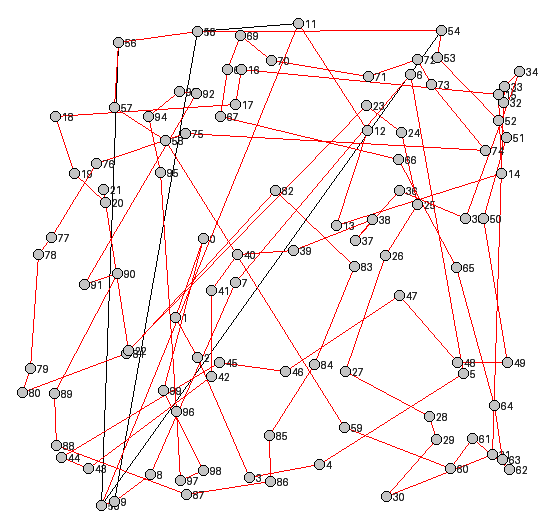

computation time  0:00:03.121432
best score: 10654.27535390392
best route: [38, 19, 31, 69, 87, 98, 71, 8, 92, 5, 68, 51, 11, 83, 6, 95, 65, 97, 36, 18, 88, 67, 30, 52, 13, 75, 4, 7, 46, 70, 33, 17, 72, 76, 55, 12, 62, 85, 80, 74, 43, 14, 20, 0, 35, 79, 59, 42, 25, 40, 93, 37, 58, 32, 94, 54, 16, 61, 63, 81, 24, 27, 89, 29, 91, 2, 64, 90, 3, 84, 48, 47, 15, 53, 45, 1, 22, 34, 21, 73, 86, 9, 49, 28, 57, 82, 60, 44, 39, 56, 96, 10, 78, 26, 41, 23, 99, 66, 77, 50]
number of evaluations done: 5000


In [11]:
# nothing has been changed to the one before except for the function name
move_operator = swapped_cities
# move_operator = reversed_sections
max_evaluations = 5000
# do_hc_evaluations(max_evaluations,move_operator)
do_hc_steepest_asc_evaluations(max_evaluations, move_operator, plot_slowdown=50e-5)

### <a style="color:orchid" id='steepest-ascent-hill-climbing-replace'>Steepest Ascent Hill Climbing mit Ersetzen</a>
<span style="color:red">Same as before, but now because of **With Replacement** we always replace the current best solution with the best successor that we found in the current n-tweaks! (before we only replaced the current best solution if the best successor of the tweaks was better)</span>

In [12]:
# i think i could copy the thing from before and just change a little bit of it

### <a style="color:orchid" id='simulated-annealing'>Simulated Annealing</a>
<span style="color:red">I don't really know how to do that? Do I just S = R if R is better OR if the forumla with the temperature? (and then in every iteration increase t??) And if R is not better then the "Best" just becomes the current S?? </span>
- **Initialization function**: Provide one or more initial candidates at random
- **Objective Function**: Return how "good" a solution is (length of the tour)

### <a style="color:orchid" id='tabu-search'>Tabu Search</a>
<span style="color:red">I think I have to add the tabu list (and maintain it) and then while searching for a new tweak always check if it is in the tabu list.</span>
- **Initialization function**: Provide one or more initial candidates at random
- **Objective Function**: Return how "good" a solution is (length of the tour)

### <a style="color:orchid" id='ils'>Interated Local Search</a>
<span style="color:red">Improved version of Hill Climbing with Random Restarts </span>
- **Initialization function**: Provide one or more initial candidates at random
- **Objective Function**: Return how "good" a solution is (length of the tour)